## Brief desciption of the problem and data
For this assignment, we are provided with 300 Monet paintings. As a painter, Claude Monet tried to capture his surroundings with a brush stroke. Nowadays, we can do the same using generative adversarial networks (GANs). We will need to develop a GAN that can generate Monet style paintings of the 7028 photos in the test set. The model can be trained on the initial 300 Monet paintings. Both the pictures and monet paintings are provided as both JPEG and TFRecords. In the end, we need to generate between 7000-10000 Monet-style images in jpg format with size 256x256x3 in an output file called images.zip.

## Downloading the datasets from the Kaggle website
We'll start by downloading the pictures from the Kaggle website and importing them appropriately.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import opendatasets as od
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset.batch(1)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

# Download the paintings and photos from Kaggle using opendatasets.
od.download("https://www.kaggle.com/competitions/gan-getting-started/data?select=monet_jpg")

print('Monet TFRecord Files:', len(tf.io.gfile.glob('gan-getting-started/monet_tfrec/*.tfrec')))
print('Photo TFRecord Files:', len(tf.io.gfile.glob('gan-getting-started/photo_tfrec/*.tfrec')))
print('Monet JPG Files:', len(tf.io.gfile.glob('gan-getting-started/monet_jpg/*.jpg')))
print('Photo JPG Files:', len(tf.io.gfile.glob('gan-getting-started/photo_jpg/*.jpg')))

monet_ds = load_dataset(tf.io.gfile.glob('gan-getting-started/monet_tfrec/*.tfrec'))
photo_ds = load_dataset(tf.io.gfile.glob('gan-getting-started/photo_tfrec/*.tfrec'))

Skipping, found downloaded files in "./gan-getting-started" (use force=True to force download)
Monet TFRecord Files: 5
Photo TFRecord Files: 20
Monet JPG Files: 300
Photo JPG Files: 7038
Metal device set to: Apple M1 Pro


## Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data
From the output above, we can see that there are 5 Tensorflow Record files for the Monet Paintings, and 20 for the Photos. We seem to have all the 300 JPG files of monet paintings and 7038 photos.

In this case, there are relatively few exploratory data analysis procedures that are truly insightful and needed. However, I will explore some aspects of these pictures to fullfil the assignment. First, let's have a look at the images and see whether they have loaded correctly:

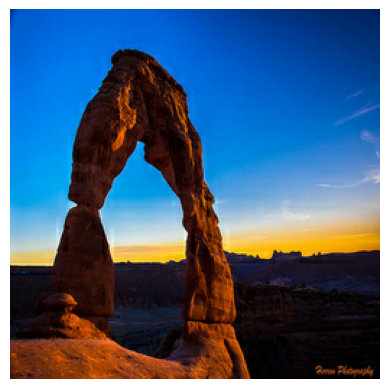

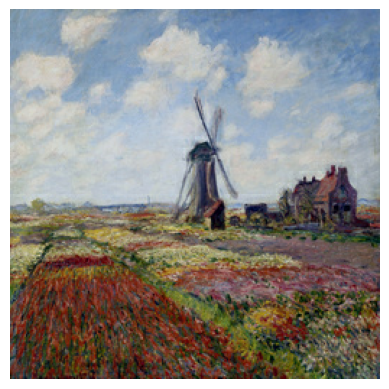

In [3]:
def show_image(dataset, index):
    image = list(dataset.skip(index).take(1))[0][0]
    plt.imshow(image * 0.5 + 0.5)
    plt.axis('off')
    plt.show()

# Show the first image in the photo dataset
show_image(photo_ds, 0)

# Show the third image in the Monet dataset
show_image(monet_ds, 3)


We can see that the images have loaded correctly. In the code I wrote, we can change the index of the image and see various versions. Next, let's create a histogram of the pixel values in the images. In some instances, that information may be useful in determining whether the normalization techniques have worked.

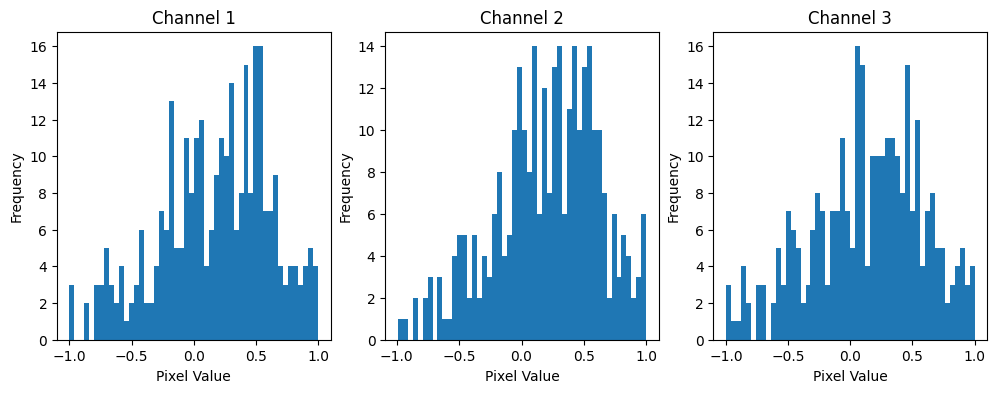

In [4]:
import numpy as np

# Flatten the pixel values of the Monet dataset
monet_pixels = [np.array(image).flatten() for image in monet_ds.unbatch()]

# Plot histograms of pixel values for each color channel
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i in range(3):
    axs[i].hist([pixels[i] for pixels in monet_pixels], bins=50)
    axs[i].set_xlabel('Pixel Value')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title('Channel ' + str(i+1))
plt.show()

We can see that the normalization around 0 has worked nicely. A roughly normally distributed histogram can be seen (altough slightly skewed to the left perhaps). Lastly, I'll try and rotate and color transform the images, to see what kind of influence that has. It may help understand and visualize how some of these transformations are part of some of the GANs and what their potential impact on model performance could be. If our model does not perform well, we could consider such data augmentations to improve performance.

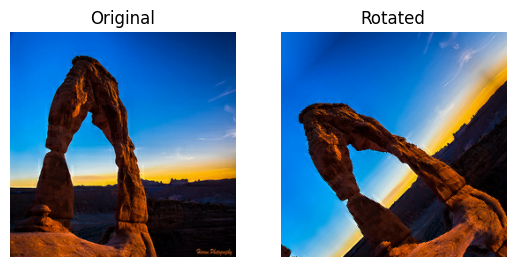

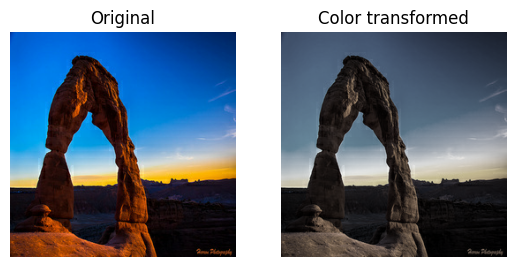

In [6]:
import tensorflow_addons as tfa

# Rotate the first image in the photos dataset by 45 degrees
image = next(iter(photo_ds))
rotated_image = tfa.image.rotate(image, 45 * np.pi / 180, fill_mode='reflect')
plt.subplot(121)
plt.imshow(image[0] * 0.5 + 0.5)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(rotated_image[0] * 0.5 + 0.5)
plt.title('Rotated')
plt.axis('off')
plt.show()

# Apply a color transformation to the first image in the photos dataset
image = next(iter(photo_ds))
color_transform = tfa.image.random_hsv_in_yiq(image, 0.2, 0.2, 0.2)
plt.subplot(121)
plt.imshow(image[0] * 0.5 + 0.5)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(color_transform[0] * 0.5 + 0.5)
plt.title('Color transformed')
plt.axis('off')
plt.show()

## Data Preprocessing
After doing some research, I have decided to use a CycleGAN approach in this instance. CycleGAN is a type of GAN that can learn to transform an image from one domain to another without a paired training dataset. It does this by learning the mapping functions between two image domains, typically referred to as the source domain and the target domain, using an adversarial loss. This is exactly what we would need for the current assigntment/challenge.

In a CycleGAN architecture, there are two GANs that are trained in parallel: a generator that maps images from one domain to the other, and a discriminator that attempts to distinguish between real and generated images in the target domain. The cycle consistency loss is used to ensure that the mapping is consistent in both directions.

To start, we first need to develop our downsampling and upsampling methods. In a CycleGAN architecture, both the generator and the discriminator networks typically use downsample and upsample methods. The downsample method reduces the spatial dimensions of the input tensor, while increasing the number of filters. This helps to extract high-level features from the image. On the other hand, the upsample method increases the spatial dimensions of the input tensor, while reducing the number of filters. This helps to generate a higher resolution image.

In [7]:
def downsample(filters, size, apply_instancenorm=True):
    result = keras.Sequential([
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False),
        (tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))
         if apply_instancenorm else layers.Lambda(lambda x: x)),
        layers.LeakyReLU()
    ])
    return result

In [8]:
def upsample(filters, size, apply_dropout=False):
    result = keras.Sequential([
        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False),
        tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02)),
        layers.Dropout(0.5) if apply_dropout else layers.Lambda(lambda x: x),
        layers.ReLU()
    ])
    return result

Next, we need to create the generator and discriminator networks. The generator network takes an input image from one domain (such as a photo) and produces a corresponding output image in another domain (such as a painting). In the  code below, the generator network takes a low-resolution image and generates a high-resolution image . The generator network consists of a series of down-sampling layers (to reduce the size of the image) followed by a series of up-sampling layers (to increase the size of the image back to the original size) with skip connections to preserve information from earlier layers. I have specifically limited the number of downsamples in the generator network to make it less computationally intensive. Otherwise, it gave me significant trouble with parameter tuning.

The discriminator network, takes an image and determines whether it is a real image from the target domain (in this case, a high-resolution image) or a fake image produced by the generator. The discriminator network consists of a series of down-sampling layers to reduce the size of the image and a final output layer that predicts whether the image is real or fake.

In [15]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                activation='tanh')(x)

    return keras.Model(inputs=inputs, outputs=x)

In [16]:
def Discriminator():
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = layers.ZeroPadding2D()(inp)
    x = downsample(64, 4, apply_instancenorm=False)(x)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1,
                      kernel_initializer=tf.random_normal_initializer(0., 0.02),
                      use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1,
                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)

    return tf.keras.Model(inputs=inp, outputs=x)

In [17]:
with strategy.scope():
    # Define generators
    monet_generator = photo_generator = Generator()

    # Define discriminators
    monet_discriminator = photo_discriminator = Discriminator()

## Model Architecture
Now that we have the generator and discriminator networks set, we can start creating the model. As described above, we will go with the CycleGAN architecture, which seems fitting for this particular problem. Let's define the model.

In [18]:
class FastCycleGAN(keras.Model):
    def __init__(self, monet_gen, photo_gen, monet_disc, photo_disc, lambda_cycle=10):
        super().__init__()
        self.m_gen = monet_gen  
        self.p_gen = photo_gen  
        self.m_disc = monet_disc  
        self.p_disc = photo_disc  
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(FastCycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, data):
        real_monet, real_photo = data

        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images and reconstruct them
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generate images from themselves (identity mapping)
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Compute the generator losses
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)  # Updated
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)  # Updated

            # Compute the total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Compute the total identity loss
            total_id_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle) + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Compute the total generator loss
            total_gen_loss = monet_gen_loss + photo_gen_loss + total_cycle_loss + total_id_loss

            # Compute the discriminator losses
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generators and discriminators
        monet_gen_gradients = tape.gradient(total_gen_loss, self.m_gen.trainable_variables)
        photo_gen_gradients = tape.gradient(total_gen_loss, self.p_gen.trainable_variables)

        monet_disc_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizers
        self.m_gen_optimizer.apply_gradients(zip(monet_gen_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_gen_gradients, self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_disc_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_disc_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": monet_gen_loss,
            "photo_gen_loss": photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss,
            "total_cycle_loss": total_cycle_loss,
            "total_id_loss": total_id_loss
        }

In a CycleGAN, several loss functions are used to train the generator and discriminator networks. The discriminator loss measures the difference between the discriminator's predictions for real and generated images. The generator loss measures the difference between the discriminator's predictions for the generated images and a target label of 1. The cycle consistency loss measures the difference between the original input image and the output image that has been cycled through both generator networks. The identity loss measures the difference between the original input image and the output image that has not been processed by the generator. These loss functions work together to encourage the generator to produce high-quality images that are consistent with the original input images and the target domain, while also ensuring that the generator doesn't change input images unnecessarily and that the discriminator is able to distinguish between real and fake images. Here we will define all of them:

In [19]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss


Now we have created all the necessary functions and can start to train the model. Let's start with a basic version:

In [20]:
# Optimizers
with strategy.scope():
    monet_gen_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_gen_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    monet_disc_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_disc_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

# Set up the model
with strategy.scope():
    fast_cycle_gan = FastCycleGAN(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )
    
    fast_cycle_gan.compile(
        m_gen_optimizer=monet_gen_optimizer,
        p_gen_optimizer=photo_gen_optimizer,
        m_disc_optimizer=monet_disc_optimizer,
        p_disc_optimizer=photo_disc_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

# Train the FastCycleGAN model
fast_cycle_gan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
300/300 [==============================] - 107s 293ms/step - monet_gen_loss: 0.7897 - photo_gen_loss: 0.8488 - monet_disc_loss: 0.6242 - photo_disc_loss: 0.5903 - total_cycle_loss: 3.5257 - total_id_loss: 1.5409
Epoch 2/10
300/300 [==============================] - 81s 269ms/step - monet_gen_loss: 0.8340 - photo_gen_loss: 0.8748 - monet_disc_loss: 0.6371 - photo_disc_loss: 0.6151 - total_cycle_loss: 2.3843 - total_id_loss: 1.0721
Epoch 3/10
300/300 [==============================] - 81s 271ms/step - monet_gen_loss: 0.8860 - photo_gen_loss: 0.8975 - monet_disc_loss: 0.6186 - photo_disc_loss: 0.6102 - total_cycle_loss: 2.3016 - total_id_loss: 1.0532
Epoch 4/10
300/300 [==============================] - 81s 270ms/step - monet_gen_loss: 0.9207 - photo_gen_loss: 0.9400 - monet_disc_loss: 0.6177 - photo_disc_loss: 0.6019 - total_cycle_loss: 2.2222 - total_id_loss: 1.0344
Epoch 5/10
300/300 [==============================] - 81s 271ms/step - monet_gen_loss: 0.9470 - photo_gen_loss:

Now that the model has trained, let's compare its Monet-esque versions with the regular photos:

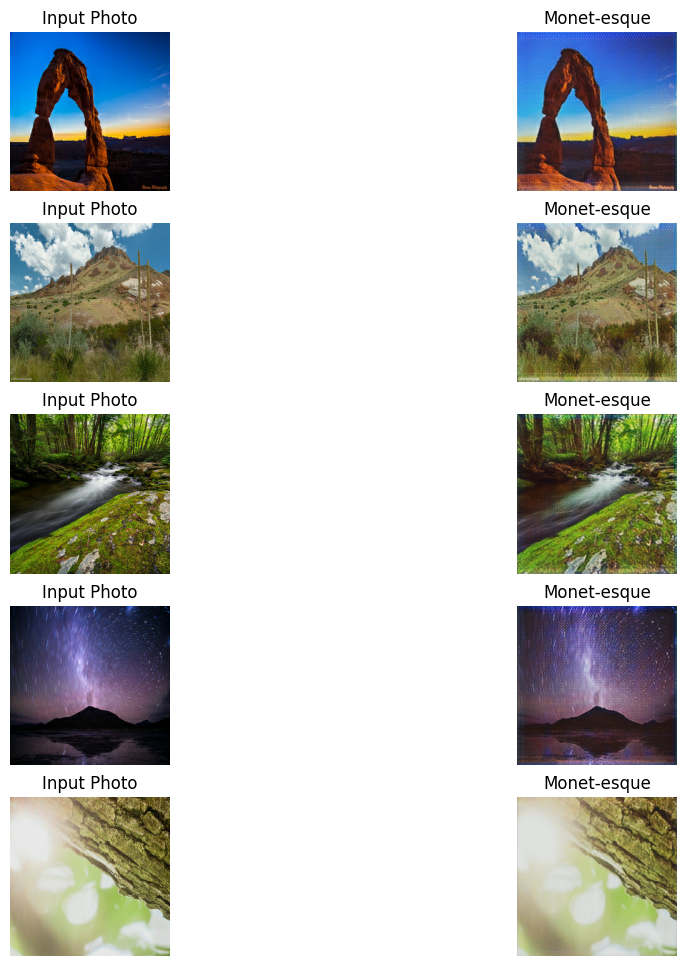

In [21]:
def display_images(n, photo_ds, monet_generator):
    fig, ax = plt.subplots(n, 2, figsize=(12, 12))
    
    for i, img in enumerate(photo_ds.take(n)):
        pred = monet_generator(img, training=False)[0].numpy()
        pred = (pred * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(pred)
        ax[i, 0].set(title="Input Photo", xticks=[], yticks=[])
        ax[i, 1].set(title="Monet-esque", xticks=[], yticks=[])

    plt.show()

display_images(5, photo_ds, monet_generator)

## Results and Analysis

We can see that the model has somewhat tried to change the input pictures. In particular, we can see slight differences when looking at the very bottom of the image. It seems that the model is functioning, but it is far from creating a truly Monet-esque painting version. It is very plausible that the currect hyperparameters are not optimal for learning the Monet-like style. Let's try once more, but now, we will lower the beta (learning rate) of the optimizer and see how it performs then:

In [22]:
# Optimizers
with strategy.scope():
    monet_gen_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.2)
    photo_gen_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.2)
    monet_disc_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.2)
    photo_disc_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.2)

# Set up the model
with strategy.scope():
    fast_cycle_gan = FastCycleGAN(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )
    
    fast_cycle_gan.compile(
        m_gen_optimizer=monet_gen_optimizer,
        p_gen_optimizer=photo_gen_optimizer,
        m_disc_optimizer=monet_disc_optimizer,
        p_disc_optimizer=photo_disc_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

# Train the FastCycleGAN model
fast_cycle_gan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=10
)

Epoch 1/10
300/300 [==============================] - 124s 336ms/step - monet_gen_loss: 0.9848 - photo_gen_loss: 0.9453 - monet_disc_loss: 0.6010 - photo_disc_loss: 0.6099 - total_cycle_loss: 1.7613 - total_id_loss: 0.8492
Epoch 2/10
300/300 [==============================] - 80s 265ms/step - monet_gen_loss: 0.9777 - photo_gen_loss: 0.9457 - monet_disc_loss: 0.6039 - photo_disc_loss: 0.6068 - total_cycle_loss: 1.7198 - total_id_loss: 0.8237
Epoch 3/10
300/300 [==============================] - 80s 265ms/step - monet_gen_loss: 0.9827 - photo_gen_loss: 0.9481 - monet_disc_loss: 0.5999 - photo_disc_loss: 0.6045 - total_cycle_loss: 1.6818 - total_id_loss: 0.7998
Epoch 4/10
300/300 [==============================] - 80s 265ms/step - monet_gen_loss: 0.9657 - photo_gen_loss: 0.9503 - monet_disc_loss: 0.6084 - photo_disc_loss: 0.6037 - total_cycle_loss: 1.6610 - total_id_loss: 0.7752
Epoch 5/10
300/300 [==============================] - 79s 264ms/step - monet_gen_loss: 0.9506 - photo_gen_loss:

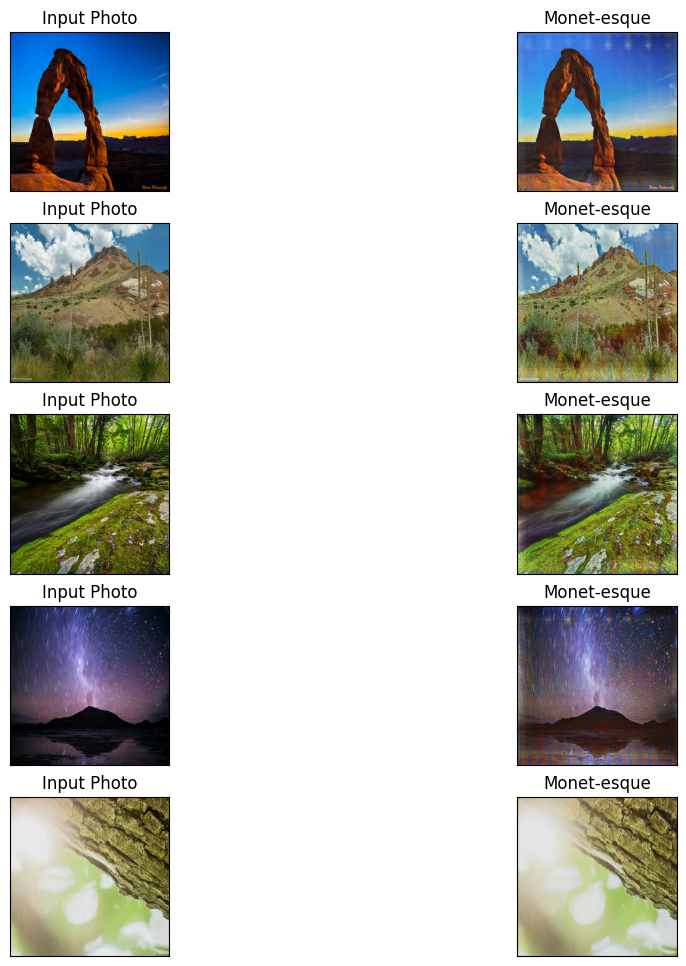

In [23]:
display_images(5, photo_ds, monet_generator)

After lowering the learning rate, we do see that the image is getting a little bit more of a Monet-like influence. Still, we are far from a truly Monet-esque painting. One reason could be that the model might need more training epochs to learn the Monet-like style. For a final attempt, lets increase the number of epochs to 25 and lower the learning rate just a little bit further to 0.1.

In [24]:
# Optimizers
with strategy.scope():
    monet_gen_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.1)
    photo_gen_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.1)
    monet_disc_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.1)
    photo_disc_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.1)

# Set up the model
with strategy.scope():
    fast_cycle_gan = FastCycleGAN(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )
    
    fast_cycle_gan.compile(
        m_gen_optimizer=monet_gen_optimizer,
        p_gen_optimizer=photo_gen_optimizer,
        m_disc_optimizer=monet_disc_optimizer,
        p_disc_optimizer=photo_disc_optimizer,
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

# Train the FastCycleGAN model
fast_cycle_gan.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 147s 375ms/step - monet_gen_loss: 0.9115 - photo_gen_loss: 0.9583 - monet_disc_loss: 0.6228 - photo_disc_loss: 0.6002 - total_cycle_loss: 1.5500 - total_id_loss: 0.6527
Epoch 2/25
300/300 [==============================] - 82s 272ms/step - monet_gen_loss: 0.8986 - photo_gen_loss: 0.9515 - monet_disc_loss: 0.6269 - photo_disc_loss: 0.6019 - total_cycle_loss: 1.5369 - total_id_loss: 0.6296
Epoch 3/25
300/300 [==============================] - 81s 270ms/step - monet_gen_loss: 0.8959 - photo_gen_loss: 0.9504 - monet_disc_loss: 0.6244 - photo_disc_loss: 0.5991 - total_cycle_loss: 1.5455 - total_id_loss: 0.6238
Epoch 4/25
300/300 [==============================] - 81s 268ms/step - monet_gen_loss: 0.8784 - photo_gen_loss: 0.9462 - monet_disc_loss: 0.6320 - photo_disc_loss: 0.6046 - total_cycle_loss: 1.5216 - total_id_loss: 0.6035
Epoch 5/25
300/300 [==============================] - 80s 267ms/step - monet_gen_loss: 0.8819 - photo_gen_loss:

Now that we have the final model, let's visualize what our Monet-esque photos for our submission look like:

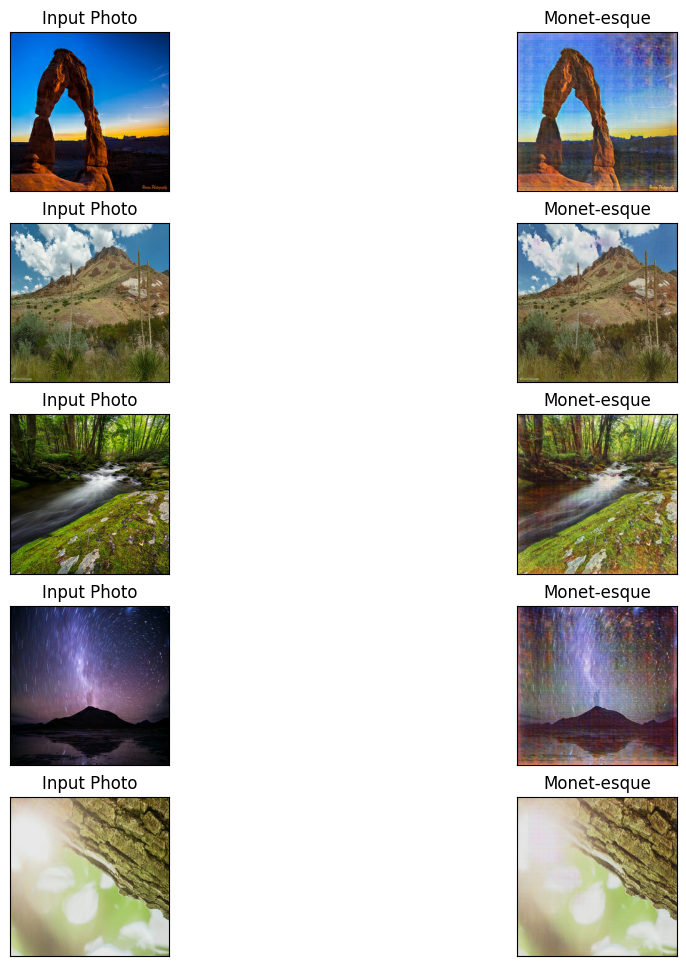

In [25]:
display_images(5, photo_ds, monet_generator)

We can see that there has been a substantial improvement over our initial try. Especially around the borders, we can see a bit of a Monet-esque influence. Let's create a zip file of images for the kaggle competition upload with the final model. 

In [26]:
import os
import shutil
from PIL import Image

def save_images(photo_ds, monet_generator, output_dir="../images"):
    os.makedirs(output_dir, exist_ok=True)
    
    for i, img in enumerate(photo_ds, start=1):
        pred = monet_generator(img, training=False)[0].numpy()
        pred = (pred * 127.5 + 127.5).astype(np.uint8)
        im = Image.fromarray(pred)
        im.save(f"{output_dir}/{i}.jpg")

    shutil.make_archive("images", 'zip', output_dir)

save_images(photo_ds, monet_generator)


## Conclusion

We have created predictions for the Kaggle competition on using GANs to turn real photos into Monet-Like artworks. When uploading these pictures to the Kaggle website, we got to the following score:

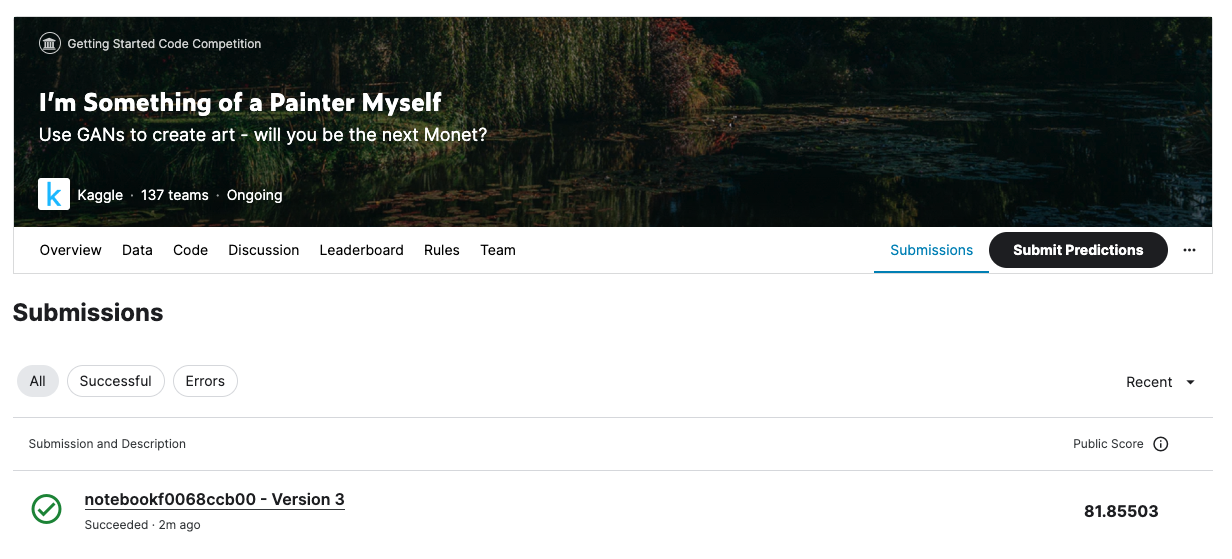

Overall, we were able to create somewhat fair Monet-esque versions of the photos and got a pretty good score at the first try. We made it to the 107th place on the leaderboard! Of course, there are many ways to further optimize the model and images. For example, we can further increase the number of epochs, add additional layers and filters (I started with more layers, but the model was way to slow to keep it practical with hyperparameter tuning), an tweak the hyperparameters further (learning rate, optimizer, loss functions). We could also take a more data-centric approach and apply data augmentation techniques to the training dataset, such as random horizontal flipping, cropping, or color jittering. I made a start with exploring those augmentations in the EDA setting. 

As a take-away, I would like to recognize that it was fairly easy to set up this pipeline for training a CycleGAN to turn photos into paintings, which I could have never imagined. Using the Monet CycleGAN tutorial on Kaggle as a rough guideline, together with what we learned in the lectures, made this a pretty enjoyable assignment from which I learned loads. For the upload to Kaggle, I found out that we need to run the notebook locally first, so I have slightly tweaked the loading of the data in that notebook, compared to this local one. The models was exactly the same.

### GitHub Repo: https://github.com/michielschinkel/Deep-Learning